In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
symbol = 'ITC.NS'
start_date = '2018-01-01'
end_date = '2024-01-22'
stock_data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df = stock_data

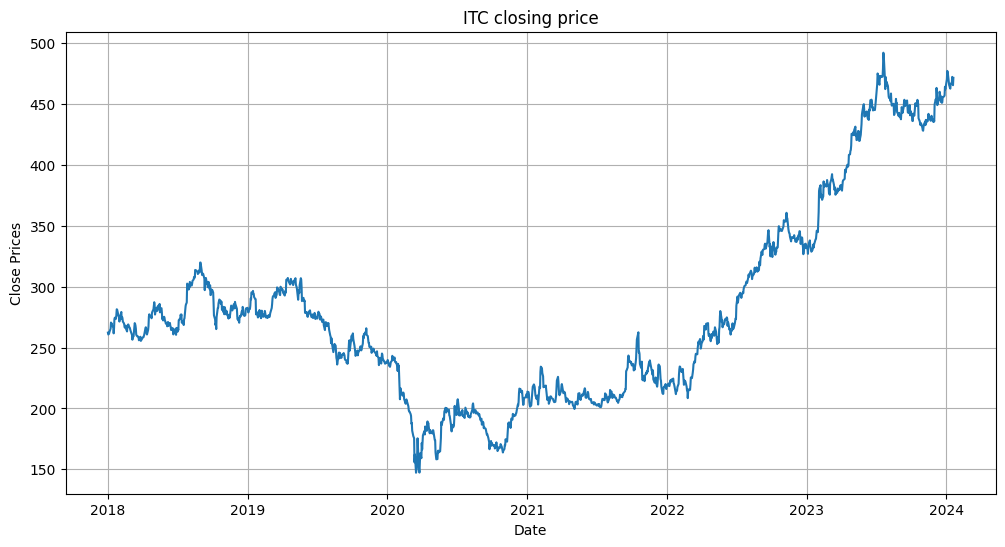

In [4]:
#plotting the close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ITC closing price')
plt.show()

# Stratergy2

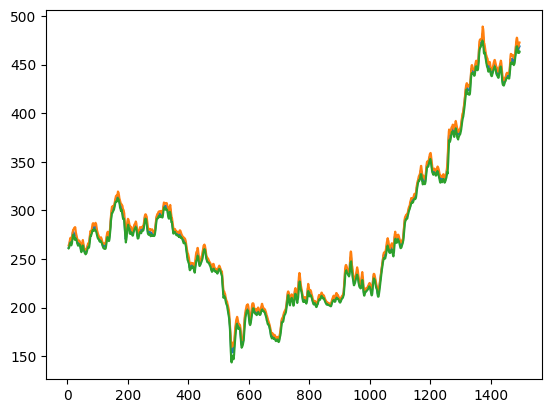

In [5]:
ts = pd.DataFrame(df[["Close", "High", "Low"]])
ts.index = np.arange(len(ts))
plt.plot(ts.rolling(5).mean())


In [6]:
ts["Movements"] = (ts['Close'].rolling(5).mean() - ts['Close'].rolling(5).mean().shift(5)).dropna()
ts["MAV_5"] = ts['Close'].rolling(5).mean()

Text(0.5, 1.0, 'Bullish Trading Days')

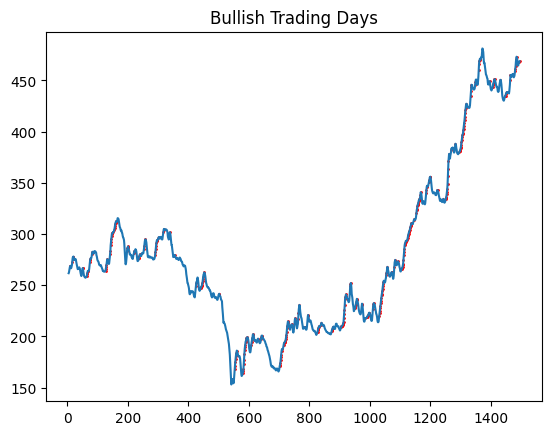

In [7]:
n = 5
ts['Close'].rolling(window=n)
ts['Increasing_5_Days'] = ts['MAV_5'].rolling(window=n).apply(lambda x: x[-1] > x[0] and all(x[i] <= x[i+1] for i in range(n-1)), raw=True)
bullish_days = ts[ts['Increasing_5_Days'] == 1].index
plt.scatter(bullish_days, ts.loc[bullish_days, 'MAV_5'] , c = 'r', s = 1)
plt.plot(ts['MAV_5'])
plt.title("Bullish Trading Days")

Text(0.5, 1.0, 'Bearish Trading Days')

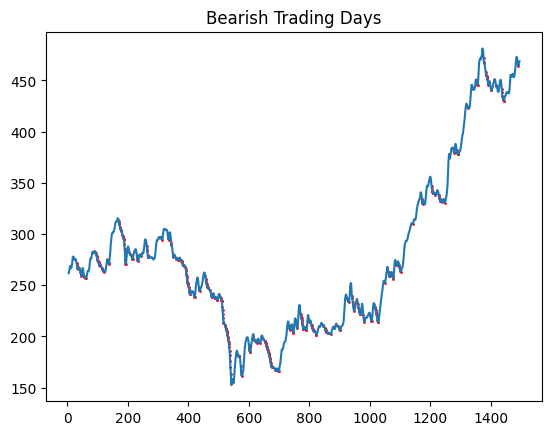

In [8]:

n = 5
ts['Close'].rolling(window=n)
ts['Decreasing_5_Days'] = ts['MAV_5'].rolling(window=n).apply(lambda x: x[-1] < x[0] and all(x[i] >= x[i+1] for i in range(n-1)), raw=True)
bullish_days = ts[ts['Decreasing_5_Days'] == 1].index
plt.scatter(bullish_days, ts.loc[bullish_days, 'MAV_5'] , c = 'r', s = 1)
plt.plot(ts['MAV_5'])
plt.title("Bearish Trading Days")

In [9]:
actual_movement = []
for i in range(len(ts)):
  if(ts.loc[i, "Increasing_5_Days"] == 1):
    actual_movement.append(1)
  elif(ts.loc[i, "Decreasing_5_Days"] == 1):
    actual_movement.append(-1)
  else:
    actual_movement.append(0)
ts["Actual Movement"] = actual_movement


In [10]:
def evaluate(ts):
  print("Overall Accuracy: ", len(ts[ts["Actual Movement"] == ts["Predicted Movement"]])/len(ts))
  x = (len(ts[(ts["Actual Movement"] == 1) & (ts["Predicted Movement"] == 1)]))/len(ts[ts["Actual Movement"]== 1]) # days on which we should buy and the prediction was also to buy
  print("ratio for buy opportunities considered: ", x)
  x = (len(ts[(ts["Actual Movement"] == 1) & (ts["Predicted Movement"] == 1)])/len(ts[ts["Predicted Movement"] == 1])) # days on which we decided to buy and it was a good decison
  print("ratio for successfull bullish: ", x)
  x = (len(ts[(ts["Actual Movement"] == -1) & (ts["Predicted Movement"] == -1)])/len(ts[ts["Actual Movement"] == -1])) # days on which we should sell and the prediction was also to sell
  print("ratio for sell opportunities considered: ", x)
  x = (len(ts[(ts["Actual Movement"] == -1) & (ts["Predicted Movement"] == -1)])/len(ts[ts["Predicted Movement"] == -1])) # days on which we decided to sell and it was a good decison
  print("ratio for successfull bearish: ", x)
  x = (len(ts[(ts["Actual Movement"] == -1) & (ts["Predicted Movement"] == 1)])/len(ts[ts["Predicted Movement"] != 0])) # Predictions for which we should sell but we buyed
  print("Type 1 Loss: ", x)


# RSI

In [11]:
def relative_strength_index(data, window):
    close_price = data['Close']
    daily_returns = close_price.diff()
    gain = np.where(daily_returns > 0, daily_returns, 0)
    loss = np.where(daily_returns < 0, -daily_returns, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
ts["RSI"] = relative_strength_index(ts, 10)


Text(0.5, 1.0, 'Calculation for threshold')

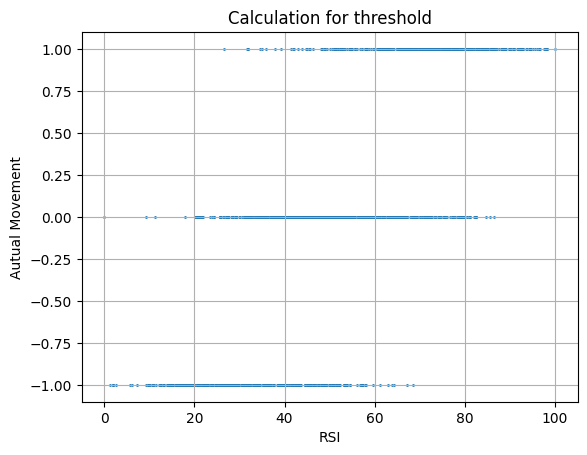

In [12]:
plt.scatter(y = "Actual Movement", x = "RSI", data = ts, s = 1)
plt.grid(True)
plt.xlabel("RSI")
plt.ylabel("Autual Movement")
plt.title("Calculation for threshold")

In [13]:
predicted_movement = []
for i in range(len(ts)):
  if(ts.loc[i, 'RSI'] > 85):
    predicted_movement.append(1)
  elif(ts.loc[i, "RSI"] < 20):
    predicted_movement.append(-1)
  else:
    predicted_movement.append(0)
ts["Predicted Movement"] = predicted_movement

In [14]:
evaluate(ts)

Overall Accuracy:  0.553475935828877
ratio for buy opportunities considered:  0.1770573566084788
ratio for successfull bullish:  0.9726027397260274
ratio for sell opportunities considered:  0.17
ratio for successfull bearish:  0.9444444444444444
Type 1 Loss:  0.0


# Using Stochastic Oscillator

In [15]:
# Calculate Stochastic Oscillator
stochastic_k_period = 14
stochastic_d_period = 3
ts['Lowest Low'] = ts['Low'].rolling(window=stochastic_k_period).min()
ts['Highest High'] = ts['High'].rolling(window=stochastic_k_period).max()
ts['%K'] = ((ts['Close'] - ts['Lowest Low']) / (ts['Highest High'] - ts['Lowest Low'])) * 100
ts['%D'] = ts['%K'].rolling(window=stochastic_d_period).mean()

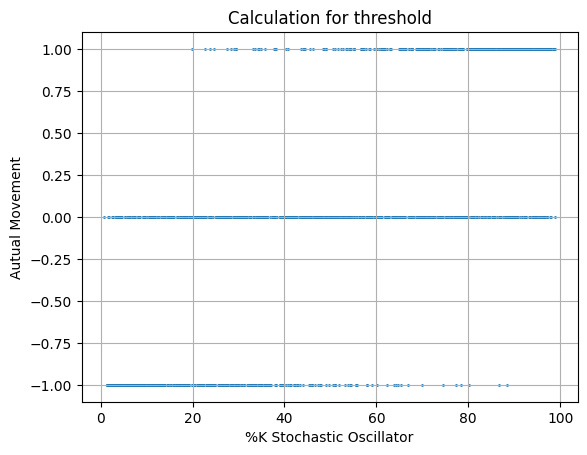

In [16]:
plt.scatter(y = "Actual Movement", x = "%K", data = ts, s = 1)
plt.xlabel("%K Stochastic Oscillator")
plt.ylabel("Autual Movement")
plt.title("Calculation for threshold")
plt.grid(True)

In [17]:
predicted_movement = []
for i in range(len(ts)):
  if(ts.loc[i, '%K'] > 60):
    predicted_movement.append(1)
  elif(ts.loc[i, "%K"] < 40):
    predicted_movement.append(-1)
  else:
    predicted_movement.append(0)
ts["Predicted Movement"] = predicted_movement

In [18]:
evaluate(ts)

Overall Accuracy:  0.5762032085561497
ratio for buy opportunities considered:  0.8603491271820449
ratio for successfull bullish:  0.5674342105263158
ratio for sell opportunities considered:  0.865
ratio for successfull bearish:  0.5414710485133021
Type 1 Loss:  0.011226944667201283


# MACD

In [19]:
def moving_average_convergence_divergence(data, fast_window, slow_window, signal_window):
    short_ema = data['Close'].ewm(span=fast_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=slow_window, adjust=False).mean()

    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram
_, _, macd = moving_average_convergence_divergence(ts, 12, 26, 9)

In [20]:
ts["MACD"] = macd


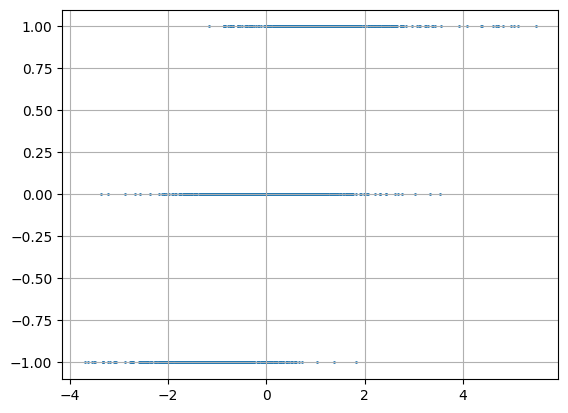

In [21]:
plt.scatter(y = "Actual Movement", x = "MACD", data = ts, s = 1)
plt.grid(True)

In [22]:
predicted_movement = []
for i in range(len(ts)):
  if(ts.loc[i, 'MACD'] > 2):
    predicted_movement.append(1)
  elif(ts.loc[i, "MACD"] < -2):
    predicted_movement.append(-1)
  else:
    predicted_movement.append(0)
ts["Predicted Movement"] = predicted_movement

In [23]:
evaluate(ts)

Overall Accuracy:  0.5447860962566845
ratio for buy opportunities considered:  0.19950124688279303
ratio for successfull bullish:  0.851063829787234
ratio for sell opportunities considered:  0.165
ratio for successfull bearish:  0.8461538461538461
Type 1 Loss:  0.0


# ATR

In [24]:
def average_true_range(data, window):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

In [25]:
ts["ATR"] = average_true_range(ts, 10)

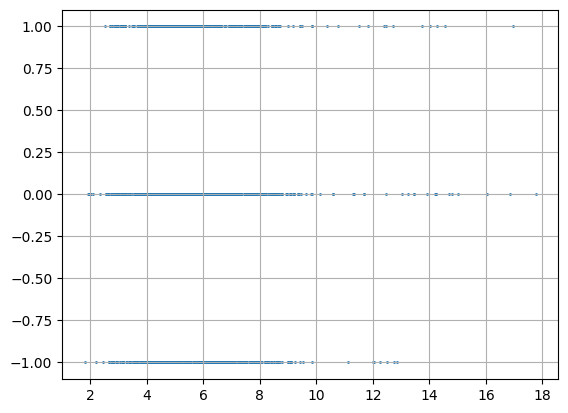

In [26]:
plt.scatter(y = "Actual Movement", x = "ATR", data = ts, s = 1)
plt.grid(True)

# ADX

In [27]:

def average_directional_index(data, window):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))

    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    positive_directional_movement = np.where((data['High'] - data['High'].shift(1)) > (data['Low'].shift(1) - data['Low']),
                                             np.maximum(data['High'] - data['High'].shift(1), 0), 0)
    negative_directional_movement = np.where((data['Low'].shift(1) - data['Low']) > (data['High'] - data['High'].shift(1)),
                                             np.maximum(data['Low'].shift(1) - data['Low'], 0), 0)

    # Convert NumPy arrays to Pandas Series
    positive_directional_movement = pd.Series(positive_directional_movement, index=data.index)
    negative_directional_movement = pd.Series(negative_directional_movement, index=data.index)

    # Calculate rolling mean using Pandas Series
    positive_directional_index = (positive_directional_movement.rolling(window=window).mean() / true_range.rolling(window=window).mean()) * 100
    negative_directional_index = (negative_directional_movement.rolling(window=window).mean() / true_range.rolling(window=window).mean()) * 100

    adx = np.abs(positive_directional_index - negative_directional_index) / (positive_directional_index + negative_directional_index) * 100

    return adx

# Example usage:
# Assuming ts is your DataFrame with columns 'High', 'Low', and 'Close'
ts["ADX"] = average_directional_index(ts, 12)



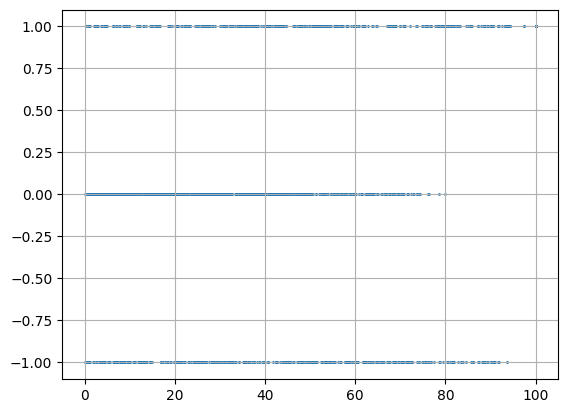

In [28]:
plt.scatter(y = "Actual Movement", x = "ADX", data = ts, s = 1)
plt.grid(True)

# Correlation analysis

In [29]:
correlation_matrix = ts[["Close", "MAV_5", "RSI", "%K", "MACD", "ATR", "ADX"]].corr()
correlation_matrix

,Close,MAV_5,RSI,%K,MACD,ATR,ADX
Close,1.000000,0.998558,0.204197,0.211948,0.014038,0.317759,-0.067661
MAV_5,0.998558,1.000000,0.175613,0.176116,-0.011979,0.320364,-0.073428
RSI,0.204197,0.175613,1.000000,0.865893,0.773361,0.052172,0.152434
%K,0.211948,0.176116,0.865893,1.000000,0.723542,0.079532,0.129440
MACD,0.014038,-0.011979,0.773361,0.723542,1.000000,0.019078,0.142671
ATR,0.317759,0.320364,0.052172,0.079532,0.019078,1.000000,-0.004191
ADX,-0.067661,-0.073428,0.152434,0.129440,0.142671,-0.004191,1.000000


In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts[["RSI", "%K", "MACD", "ATR", "ADX"]] = scaler.fit_transform(ts[["RSI", "%K", "MACD", "ATR", "ADX"]])

In [31]:
weights = {"RSI" : 0.4, "%K" : 0.4, "MACD" : 0.2, "ATR" : 0.05, "ADX" : 0.05}
ts["Combined Indicator"] = ts["RSI"] * weights["RSI"] + ts["%K"] * weights["%K"] + ts["MACD"] * weights["MACD"] + ts["ATR"] * weights["ATR"] + ts["ADX"] * weights["ADX"]

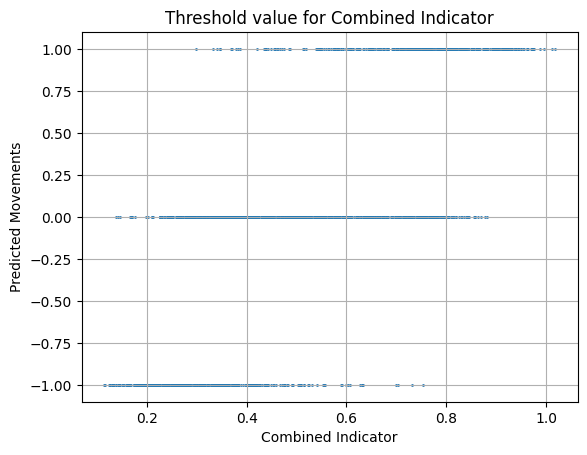

In [32]:
plt.scatter(y = "Actual Movement", x = "Combined Indicator", data = ts, s = 1)
plt.title("Threshold value for Combined Indicator")
plt.xlabel("Combined Indicator")
plt.ylabel("Predicted Movements")
plt.grid(True)

In [33]:
# Selected threshold are 0.75 for Long and 0.22 for Short
predicted_movement = []
for i in range(len(ts)):
  if(ts.loc[i, 'Combined Indicator'] > 0.75):
    predicted_movement.append(1)
  elif(ts.loc[i, "Combined Indicator"] < 0.22):
    predicted_movement.append(-1)
  else:
    predicted_movement.append(0)
ts["Predicted Movement"] = predicted_movement

In [34]:
evaluate(ts)

Overall Accuracy:  0.6256684491978609
ratio for buy opportunities considered:  0.5760598503740648
ratio for successfull bullish:  0.752442996742671
ratio for sell opportunities considered:  0.245
ratio for successfull bearish:  0.8828828828828829
Type 1 Loss:  0.0023923444976076554


In [36]:
ts.to_csv('ts.csv',index=False)